In [37]:
import pandas as pd
import numpy as np
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import json
from nltk import word_tokenize

from utils import create_windowed_dataset, get_penn_treebank_tags

In [38]:
CHECKPOINT_DIR = 'data/model/pos_checkpoint'
sequence_length = 5 # centre word, 2 before and 2 after
UNK_WORD = '<UNK_WORD>'

In [39]:
train = pd.read_csv('data/WSJ_02-21.pos', sep='\t', header=0, names=['word', 'pos'])
train.head()

,word,pos
0,an,DT
1,Oct.,NNP
2,19,CD
3,review,NN
4,of,IN


In [40]:
# find most common pos to apply to unk words in feature creation
MOST_COMMON_POS = Counter(train['pos']).most_common(1)

In [41]:
# Strip some non pos tags from the input data
tidy = get_penn_treebank_tags()

tags_for_removal = set(train.pos.values)- set(tidy.keys())
print(f'tags in training, but not in the original treebank set: {tags_for_removal}')
train = train[train['pos'].map(lambda x: x not in tags_for_removal)]

tags in training, but not in the original treebank set: {'(', "''", '.', '$', ')', ',', '#', ':', '``'}


In [42]:
input_data = []
for tup in train.itertuples(index=False, name=None):
    input_data.append(tup)
input_data[:5]

[('an', 'DT'), ('Oct.', 'NNP'), ('19', 'CD'), ('review', 'NN'), ('of', 'IN')]

In [43]:
train_matrix = create_windowed_dataset(input_data, sequence_length, mode='train')
train_matrix[:5]

[[('an', 'DT'), ('Oct.', 'NNP'), ('19', 'CD'), ('review', 'NN'), ('of', 'IN')],
 [('Oct.', 'NNP'),
  ('19', 'CD'),
  ('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT')],
 [('19', 'CD'),
  ('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN')],
 [('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN'),
  ('at', 'IN')],
 [('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN'),
  ('at', 'IN'),
  ('Chicago', 'NNP')]]

In [44]:
suffixes = []
for item in set(train['word']):
    suffixes.append(item[-3:])
    
initial_letters = []
for item in set(train['word']):
    initial_letters.append(item[0])
    
pos_vocab = set(train['pos'])
index_to_pos = {k:v for k, v in enumerate(pos_vocab)}
pos_to_index = {v:k for k, v in index_to_pos.items()}



word_vocab = set([UNK_WORD])
word_vocab.update(train['word'])
print(len(word_vocab))

word_vocab.update(suffixes)
print(len(word_vocab))

word_vocab.update(initial_letters)
print(len(word_vocab))

index_to_word = {k+len(pos_vocab): v for k, v in enumerate(word_vocab)}
word_to_index = defaultdict(None, {v:k for k, v in index_to_word.items()})

print(len(word_vocab), len(pos_vocab))

44364
47525
47546
47546 36


In [45]:
# For each word in the vocab determine the most common pos tag
winners = defaultdict()

for row in Counter(list(train.itertuples(index=False, name=None))):
    if row[0] not in winners:
        winners[row[0]] = row[1]
    elif winners[row[0]]< row[1]:
        winners[row[0]] = row[1]
        
print(f'There are {len(winners)} tuples in the dict')

for key in list(winners.keys())[:5]:
    print(key, winners[key])

There are 44363 tuples in the dict
an DT
Oct. NNP
19 CD
review VBP
of RP


In [10]:
# Dump the dictionaries for use in the js

with open('jq/word_to_index.json', 'wt') as f:
    f.write(json.dumps(word_to_index))
    
with open('jq/pos_to_index.json', 'wt') as f:
    f.write(json.dumps(pos_to_index))
    
with open('jq/index_to_pos.json', 'wt') as f:
    f.write(json.dumps(index_to_pos))    
    
with open('jq/most_common_tag_for_word.json', 'wt') as f:
    f.write(json.dumps(winners))

In [46]:
def build_features(matrix, mode='train'):
    transformed_matrix = []

    for row in matrix:
        features = []

        if mode=='train':
            features.append(pos_to_index[row[1][1]])
            features.append(pos_to_index[row[0][1]])
        else:
            features.append(pos_to_index[winners.get(row[1][0], 'NN')])
            features.append(pos_to_index[winners.get(row[0][0], 'NN')])
            
        features.append(word_to_index.get(row[2][0][-3:], word_to_index[UNK_WORD]))
        features.append(word_to_index.get(row[2][0][0], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[2][0], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[1][0], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[1][0][-3:], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[0][0], word_to_index[UNK_WORD]))
        features.append(word_to_index.get(row[3][0], word_to_index[UNK_WORD]))    
        features.append(word_to_index.get(row[3][0][-3:], word_to_index[UNK_WORD]))
        features.append(word_to_index.get(row[4][0], word_to_index[UNK_WORD]))
        
        if mode=='train':
            features.append(pos_to_index[row[2][1]])
        
        transformed_matrix.append(features)
    return transformed_matrix

In [47]:
transformed_matrix = build_features(train_matrix, mode='train')
transformed_matrix[:5]

[[12, 15, 25731, 15198, 25731, 14147, 15920, 21676, 2380, 31265, 3581, 32],
 [32, 12, 31265, 35132, 2380, 25731, 25731, 14147, 3581, 3581, 5130, 13],
 [13, 32, 3581, 41015, 3581, 2380, 31265, 25731, 5130, 5130, 17990, 27],
 [27, 13, 5130, 40200, 5130, 3581, 3581, 2380, 17990, 22513, 1765, 15],
 [15, 27, 22513, 21251, 17990, 5130, 5130, 3581, 1765, 1765, 779, 13]]

In [13]:
def get_model(vocab_size, d_model):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=11))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(len(pos_vocab), activation='sigmoid'))

    return model

In [14]:
model = get_model(len(word_vocab)+len(pos_vocab), 100)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           4758200   
_________________________________________________________________
flatten (Flatten)            (None, 1100)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               110100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                3636      
Total params: 4,871,936
Trainable params: 4,871,936
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy()
              , metrics=[keras.metrics.CategoricalAccuracy()])

In [16]:
X, y = np.array(transformed_matrix)[:, :-1], keras.utils.to_categorical(np.array(transformed_matrix)[:, -1], num_classes=len(pos_vocab))
print(X.shape, y.shape)

max_train_size = 50000

X_train = X[:max_train_size]
X_test = X[max_train_size:max_train_size+int(.1*max_train_size)]

y_train = y[:max_train_size]
y_test = y[max_train_size:max_train_size+int(.1*max_train_size)]

(832779, 11) (832779, 36)


Epoch 1/10
1563/1563 [==============================] - 64s 41ms/step - loss: 1.1298 - categorical_accuracy: 0.7214 - val_loss: 0.1802 - val_categorical_accuracy: 0.9446
INFO:tensorflow:Assets written to: data/model/pos_checkpoint/assets
Epoch 2/10
1563/1563 [==============================] - 60s 39ms/step - loss: 0.0918 - categorical_accuracy: 0.9739 - val_loss: 0.1873 - val_categorical_accuracy: 0.9436
Epoch 3/10
1563/1563 [==============================] - 60s 39ms/step - loss: 0.0324 - categorical_accuracy: 0.9911 - val_loss: 0.2032 - val_categorical_accuracy: 0.9444


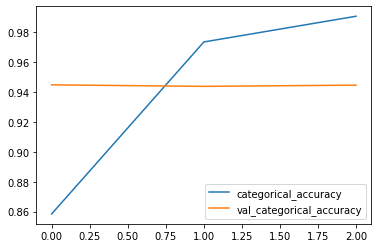

In [17]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=10, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
                              tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_DIR, monitor='val_categorical_accuracy',
                                                                save_best_only=True)])

for key in ['categorical_accuracy', 'val_categorical_accuracy']:
    plt.plot(history.history[key], label=key)
plt.legend()
plt.show()

In [24]:
# Rough test by predicting 1000 test vals against ground truth
results = []
for a in range(1000):
    results.append(np.argmax(model.predict(X_test[a].reshape(1,-1)))==np.argmax(y_test[a]))
    if not a%100:
        print(np.mean(results))

1.0
0.9306930693069307
0.9353233830845771
0.9435215946843853
0.940149625935162
0.9441117764471058
0.9484193011647255
0.9514978601997147
0.951310861423221
0.9500554938956715


In [71]:
model = tf.keras.models.load_model('data/model/pos_checkpoint/1')

# Make predictions on large body of text

In [48]:
with open('data/bleak.txt', 'rt') as f:
    content = f.read()
print(content[:100])

﻿CHAPTER I

In Chancery


London. Michaelmas term lately over, and the Lord Chancellor sitting
in Li


In [49]:
# strip some punctuation
tokens = word_tokenize(content)
tokens = [token for token in tokens if token not in list(',.;()\'!?')+['--']+['\'\'']+['``']]

In [50]:
tokens[:20]

['\ufeffCHAPTER',
 'I',
 'In',
 'Chancery',
 'London',
 'Michaelmas',
 'term',
 'lately',
 'over',
 'and',
 'the',
 'Lord',
 'Chancellor',
 'sitting',
 'in',
 'Lincoln',
 "'s",
 'Inn',
 'Hall',
 'Implacable']

In [51]:
predict_matrix = create_windowed_dataset(tokens,sequence_length, mode='predict')
predict_matrix[:5]

[[('\ufeffCHAPTER', None),
  ('I', None),
  ('In', None),
  ('Chancery', None),
  ('London', None)],
 [('I', None),
  ('In', None),
  ('Chancery', None),
  ('London', None),
  ('Michaelmas', None)],
 [('In', None),
  ('Chancery', None),
  ('London', None),
  ('Michaelmas', None),
  ('term', None)],
 [('Chancery', None),
  ('London', None),
  ('Michaelmas', None),
  ('term', None),
  ('lately', None)],
 [('London', None),
  ('Michaelmas', None),
  ('term', None),
  ('lately', None),
  ('over', None)]]

In [52]:
transformed_matrix = build_features(predict_matrix, mode='predict')

In [53]:
transformed_matrix[:5]

[[34, 13, 12291, 24721, 12291, 24721, 24721, 17702, 42990, 2909, 17232],
 [29, 34, 2909, 17179, 42990, 12291, 12291, 24721, 17232, 18048, 17702],
 [12, 29, 18048, 11727, 17232, 42990, 2909, 12291, 17702, 8208, 11146],
 [12, 12, 8208, 21251, 17702, 17232, 18048, 42990, 11146, 42175, 39714],
 [13, 12, 42175, 32981, 11146, 17702, 8208, 17232, 39714, 656, 10763]]

In [75]:
parts_of_speech = [index_to_pos[a] for a in np.argmax(model.predict(np.array(transformed_matrix)), axis=1)]

In [33]:
# Zip predicted parts of speech together with words taking account of missing leading and ending tags
results = []
for a in zip(tokens[2:-2], parts_of_speech):
    results.append(a)
print(len(results))
results[:10]

358608


[('In', 'IN'),
 ('Chancery', 'NNP'),
 ('London', 'NNP'),
 ('Michaelmas', 'NNP'),
 ('term', 'NN'),
 ('lately', 'RB'),
 ('over', 'RB'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('Lord', 'NNP')]

In [34]:
pd.DataFrame(results, columns = ['word', 'pos']).to_csv('data/pos_tagged_bleak_house_FULL.csv')

In [2]:
import requests
import json

In [66]:
r = requests.post(url='http://localhost:8501/v1/models/pos_checkpoint:predict', 
              data=json.dumps({"instances": transformed_matrix}))
preds_from_serving = r.json()['predictions']

In [80]:
parts_of_speech_from_serving = [index_to_pos[a] for a in np.argmax(np.array(preds_from_serving), axis=1)]
parts_of_speech_from_serving[:10]

['VBD', 'UH', 'VBD', 'CC', 'MD', 'VBD', 'MD', 'MD', 'MD', 'VBD']

In [79]:
parts_of_speech==parts_of_speech_from_serving

True